### OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2020-09-21 18:00:10--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 172.67.171.76, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

100%[======================================>] 9,912,422   9.91MB/s   in 1.0s   

2020-09-21 18:00:11 (9.91 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-09-21 18:00:13--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 172.67.171.76, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

100%[======================================>] 28,881      --.-

In [14]:
%matplotlib inline

import idx2numpy
import numpy as np

trainfile = 'train-images-idx3-ubyte'
trainfilelabels = 'train-labels-idx1-ubyte'
testfile = 't10k-images-idx3-ubyte'
testfilelabels = 't10k-labels-idx1-ubyte'

In [16]:
x_train = idx2numpy.convert_from_file(trainfile)
y_train = idx2numpy.convert_from_file(trainfilelabels)
x_test = idx2numpy.convert_from_file(testfile)
y_test = idx2numpy.convert_from_file(testfilelabels)

In [17]:
x_train.shape

(60000, 28, 28)

In [18]:
y_train.shape

(60000,)

In [19]:
x_test.shape

(10000, 28, 28)

In [20]:
y_test.shape

(10000,)

In [21]:
x_train[5]


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  13,  25, 100, 122,   7,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

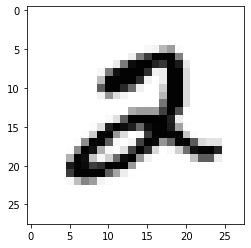

In [22]:
import matplotlib.pyplot as plt

plt.imshow(x_train[5], cmap='Greys')

In [23]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

In [24]:
x_train.shape

(60000, 784)

In [25]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [26]:
x_train[5]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [28]:
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 784)
Number of images in x_train 60000
Number of images in x_test 10000


In [29]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(16, input_shape=(784, ), activation=tf.nn.relu))
model.add(Dense(16, activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))

In [30]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(16, input_shape=(784, ), activation=tf.nn.relu))
model.add(Dense(16, activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x=x_train, y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 9s 143us/step - loss: 0.4360 - accuracy: 0.8727
Epoch 2/10
60000/60000 [==============================] - 9s 147us/step - loss: 0.2277 - accuracy: 0.9334
Epoch 3/10
60000/60000 [==============================] - 10s 169us/step - loss: 0.1946 - accuracy: 0.9431
Epoch 4/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.1728 - accuracy: 0.9497
Epoch 5/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.1600 - accuracy: 0.9530
Epoch 6/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.1488 - accuracy: 0.9554
Epoch 7/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.1408 - accuracy: 0.9584
Epoch 8/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.1334 - accuracy: 0.9597
Epoch 9/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.1265 - accuracy: 0.9618
Epoch 10/10
60000/60000 [===================

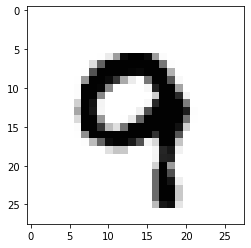

In [33]:
plt.imshow(x_test[99].reshape(28, 28),cmap='Greys')

In [35]:
y_test[99]

9

In [36]:
predict = model.predict(x_test[99].reshape(1,784))
print(predict.argmax())

9


In [37]:
model.evaluate(x_test, y_test)


10000/10000 [==============================] - 1s 101us/step


[0.15417675812430678, 0.9549000263214111]